<a href="https://colab.research.google.com/github/theovincent/CPDE/blob/make_ipynb_working/TEP_scores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup (for colab only)

In [ ]:
! git clone https://github.com/theovincent/CPDE.git -b make_ipynb_working

Cloning into 'CPDE'...
remote: Enumerating objects: 259, done.
remote: Counting objects: 100% (259/259), done.
remote: Compressing objects: 100% (212/212), done.
remote: Total 259 (delta 99), reused 173 (delta 44), pack-reused 0
Receiving objects: 100% (259/259), 5.95 MiB | 12.54 MiB/s, done.
Resolving deltas: 100% (99/99), done.


In [ ]:
import os 

os.chdir("/content/CPDE")

! pip install -r requirements.txt

In [ ]:
! git pull

Already up to date.


## Imports

In [12]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from tqdm import tqdm

import ruptures as rpt
from utils.custom_cost import CostNew
from SKAB_data.evaluating import evaluating_change_point

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
from ensemble_methods.aggregations import SCALING_AGGREGATION_PAPER, SCALING_AGGREGATION_INVESTIGATION

SINGLE_COSTS = (
    {'name': 'ar_1', 'cost':'ar', 'params':{'order':1}},
    {'name': 'ar_5', 'cost':'ar', 'params':{'order':5}},
    {'name': 'mahalanobis', 'cost':'mahalanobis', 'params':{}},
    {'name': 'l1', 'cost':'l1', 'params':{}},
    {'name': 'l2', 'cost':'l2', 'params':{}},
    {'name': 'linear', 'cost':'linear', 'params':{}}
)

DESIRED_ORDER = ["Standart", "LowFP", "LowFN"]

## Load data

In [14]:
from glob import glob

from sklearn.preprocessing import StandardScaler

# Get the data
files = sorted(glob('TEP_data/*_te.dat'))

columns=[]
for i in range(1, 42):
    columns.append("XMEAS({})".format(i))
for i in range(1, 12):
    columns.append("XMV({})".format(i))

# We do not use the first file because it does not contain a defect
test = {}
for i, j in enumerate(files[1:], start=1):
    test[i] = pd.read_table(j, sep="\s+", names=columns)

# Standardise
for idx_data in test:
    stsc = StandardScaler()
    test[idx_data] = pd.DataFrame(stsc.fit_transform(test[idx_data]), columns=test[idx_data].columns, index=test[idx_data].index)


# Get the labels
INDEX = pd.to_datetime(
        [datetime(2020,1,1)+timedelta(minutes=m) for m in test[1].index*3]
    )
true_cp = pd.Series(data=0, index=INDEX)
# Out of the 48 hours of monitoring, the faults were introduced 8 hours after the beginning
true_cp.iloc[160] = 1
true_cp = [true_cp]*len(test)

## Visualize a signal

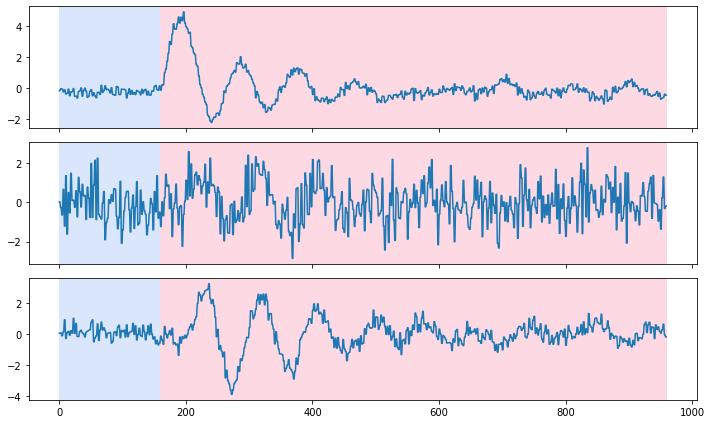

In [ ]:
_ = rpt.display(test[1].values[:, 30: 33], [160, 960])

## Window search

In [15]:
def window_search(cost, params, **kwargs):
    predicted_cp = []
    for idx_data in test:
        algo = rpt.Window(model=cost, 
                          params=params, 
                          width=20,
                          jump=1)
        algo.fit(np.array(test[idx_data]))
        my_bkps = algo.predict(n_bkps=1)
        
        single_predicted_cp = pd.Series(data=0, index=true_cp[0].index)
        single_predicted_cp[single_predicted_cp.index[my_bkps[:-1]]] = 1
        predicted_cp.append(single_predicted_cp)

    nab = evaluating_change_point(true_cp, predicted_cp, metric='nab', numenta_time='288 min')
    return nab

table_costs_window = {}
for cost in tqdm(SINGLE_COSTS):
    table_costs_window[cost["name"]] = window_search(**cost)

pd.DataFrame(table_costs_window).T[DESIRED_ORDER]

100%|██████████| 6/6 [00:30<00:00,  5.14s/it]


,Standart,LowFP,LowFN
ar_1,21.27,21.02,22.12
ar_5,13.23,12.19,13.59
mahalanobis,27.79,27.00,28.05
l1,20.63,19.85,21.69
l2,22.09,21.68,22.66
linear,0.00,0.00,0.00


In [21]:
def window_search_ensemble_bound():
    predicted_cp = []
    for idx_data in tqdm(test):
        best_nab_sum = - float("inf")
        best_single_predicted_cp = pd.Series(data=0, index=true_cp[0].index)

        for model in SINGLE_COSTS:
            algo = rpt.Window(model=model["cost"], 
                            params=model["params"], 
                            width=20,
                            jump=1)
            algo.fit(np.array(test[idx_data]))
            my_bkps = algo.predict(n_bkps=1)
            
            single_predicted_cp = pd.Series(data=0, index=true_cp[0].index)
            single_predicted_cp[single_predicted_cp.index[my_bkps[:-1]]] = 1
            
            nab_model = evaluating_change_point([true_cp[0]], [single_predicted_cp], metric='nab', numenta_time='288 min')
            
            if sum(list(nab_model.values())) > best_nab_sum:
                best_nab_sum = sum(list(nab_model.values()))
                best_single_predicted_cp = single_predicted_cp
                
        predicted_cp.append(best_single_predicted_cp)

    nab = evaluating_change_point(true_cp, predicted_cp, metric='nab', numenta_time='288 min')
    return nab

window_ensemble_bound = window_search_ensemble_bound()
pd.DataFrame(window_ensemble_bound, index=["Ensemble bound"])[DESIRED_ORDER]

100%|██████████| 21/21 [00:30<00:00,  1.45s/it]


,Standart,LowFP,LowFN
Ensemble bound,42.35,42.07,42.52


In [ ]:
from ensemble_methods.window_ensemble import WindowEnsemble

def window_search_ensemble(scale_aggregation):
    predicted_cp = []
    for idx_data in test:
        algo = WindowEnsemble(custom_cost=CostNew(), 
                                    jump=1, 
                                    scale_aggregation=scale_aggregation, 
                                    width=20)
        single_predicted_cp = pd.Series(data=0, index=true_cp[0].index)
        
        try:
            algo.fit(np.array(test[idx_data]))
            my_bkps = algo.predict(n_bkps=1)

            single_predicted_cp[single_predicted_cp.index[my_bkps[:-1]]] = 1
            predicted_cp.append(single_predicted_cp)
        except:
            predicted_cp.append(single_predicted_cp)

    nab = evaluating_change_point(true_cp, predicted_cp, metric='nab', numenta_time='288 min')
    return nab

In [ ]:
table_ensemble_window = {}
for scale_aggregation_name, scale_aggregation in tqdm(SCALING_AGGREGATION_PAPER.items()):
    table_ensemble_window[scale_aggregation_name] = window_search_ensemble(scale_aggregation)

pd.DataFrame(table_ensemble_window).T[DESIRED_ORDER]

  0%|          | 0/16 [00:00<?, ?it/s]/content/CPDE/utils/custom_cost.py:93: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  _, residual, _, _ = lstsq(X, y)
  6%|▋         | 1/16 [00:18<04:33, 18.25s/it]/content/CPDE/utils/custom_cost.py:93: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  _, residual, _, _ = lstsq(X, y)
 12%|█▎        | 2/16 [00:36<04:16, 18.34s/it]/content/CPDE/utils/custom_cost.py:93: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are th

,Standart,LowFP,LowFN
Min_MinMax,32.04,31.91,32.47
Min_Znorm,31.78,31.39,32.30
Min_MinAbs,25.46,24.92,26.50
Min_Rank,31.78,31.39,32.30
Sum_MinMax,27.28,27.15,27.71
Sum_Znorm,27.28,27.15,27.71
Sum_MinAbs,26.58,26.14,27.24
Sum_Rank,32.04,31.91,32.47
WeightedSum_MinMax,27.28,27.15,27.71
WeightedSum_Znorm,13.48,12.69,13.75


In [ ]:
table_ensemble_window_investigation = {}
for scale_aggregation_name, scale_aggregation in tqdm(SCALING_AGGREGATION_INVESTIGATION.items()):
    table_ensemble_window_investigation[scale_aggregation_name] = window_search_ensemble(scale_aggregation)

pd.DataFrame(table_ensemble_window_investigation).T[DESIRED_ORDER]

  0%|          | 0/6 [00:00<?, ?it/s]/content/CPDE/utils/custom_cost.py:93: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  _, residual, _, _ = lstsq(X, y)
 17%|█▋        | 1/6 [00:18<01:32, 18.58s/it]/content/CPDE/utils/custom_cost.py:93: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  _, residual, _, _ = lstsq(X, y)
 33%|███▎      | 2/6 [00:37<01:15, 18.79s/it]/content/CPDE/utils/custom_cost.py:93: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the i

,Standart,LowFP,LowFN
Min_MinMax,32.04,31.91,32.47
Min_Raw,28.96,28.05,32.00
Max_MinMax,16.34,15.60,18.83
Max_Raw,26.35,25.65,27.09
WeightedSum_MinMax,27.28,27.15,27.71
WeightedSum_Raw,27.28,27.15,27.71


## Dynamic Programming

In [16]:
def dynp_search(cost, params, **kwargs):
    predicted_cp = []
    for idx_data in test:
        algo = rpt.Dynp(model=cost, 
                          params=params,
                          jump=1)
        algo.fit(np.array(test[idx_data]))
        my_bkps = algo.predict(n_bkps=1)
        
        single_predicted_cp = pd.Series(data=0, index=true_cp[0].index)
        single_predicted_cp[single_predicted_cp.index[my_bkps[:-1]]] = 1
        predicted_cp.append(single_predicted_cp)

    nab = evaluating_change_point(true_cp, predicted_cp, metric='nab', numenta_time='288 min')
    return nab

table_costs_dynp = {}
for cost in tqdm(SINGLE_COSTS):
    table_costs_dynp[cost["name"]] = dynp_search(**cost)

pd.DataFrame(table_costs_dynp).T[DESIRED_ORDER]

100%|██████████| 6/6 [03:00<00:00, 30.14s/it]


,Standart,LowFP,LowFN
ar_1,30.15,28.89,32.80
ar_5,29.74,28.20,32.53
mahalanobis,36.88,35.82,37.29
l1,32.53,31.98,32.80
l2,30.30,29.52,31.31
linear,4.50,4.24,4.59


In [20]:
def dynp_search_ensemble_bound():
    predicted_cp = []
    for idx_data in tqdm(test):
        best_nab_sum = - float("inf")
        best_single_predicted_cp = pd.Series(data=0, index=true_cp[0].index)

        for model in SINGLE_COSTS:
            algo = rpt.Dynp(model=model["cost"], 
                          params=model["params"],
                          jump=1)
            algo.fit(np.array(test[idx_data]))
            my_bkps = algo.predict(n_bkps=1)
            
            single_predicted_cp = pd.Series(data=0, index=true_cp[0].index)
            single_predicted_cp[single_predicted_cp.index[my_bkps[:-1]]] = 1
            
            nab_model = evaluating_change_point([true_cp[0]], [single_predicted_cp], metric='nab', numenta_time='288 min')
            
            if sum(list(nab_model.values())) > best_nab_sum:
                best_nab_sum = sum(list(nab_model.values()))
                best_single_predicted_cp = single_predicted_cp
                
        predicted_cp.append(best_single_predicted_cp)

    nab = evaluating_change_point(true_cp, predicted_cp, metric='nab', numenta_time='288 min')
    return nab

dynp_ensemble_bound = dynp_search_ensemble_bound()
pd.DataFrame(dynp_ensemble_bound, index=["Ensemble bound"])[DESIRED_ORDER]

100%|██████████| 21/21 [02:56<00:00,  8.40s/it]


,Standart,LowFP,LowFN
Ensemble bound,37.78,37.52,37.89


In [ ]:
from ensemble_methods.dynamic_programming_ensemble import DynpEnsemble

def dynamique_programming_ensemble(scale_aggregation):
    predicted_cp = []
    for idx_data in test:
        algo = DynpEnsemble(custom_cost=CostNew(), 
                                    jump=1, 
                                    scale_aggregation=scale_aggregation
                                    )
        single_predicted_cp = pd.Series(data=0, index=true_cp[0].index)
        
        try:
            algo.fit(np.array(test[idx_data]))
            my_bkps = algo.predict(n_bkps=1)

            single_predicted_cp[single_predicted_cp.index[my_bkps[:-1]]] = 1
            predicted_cp.append(single_predicted_cp)
        except:
            predicted_cp.append(single_predicted_cp)

    nab = evaluating_change_point(true_cp, predicted_cp, metric='nab', numenta_time='288 min')
    return nab

In [ ]:
table_ensemble_dynp = {}
for scale_aggregation_name, scale_aggregation in tqdm(SCALING_AGGREGATION_PAPER.items()):
    table_ensemble_dynp[scale_aggregation_name] = dynamique_programming_ensemble(scale_aggregation)

pd.DataFrame(table_ensemble_dynp).T[DESIRED_ORDER]

  0%|          | 0/16 [00:00<?, ?it/s]/content/CPDE/utils/custom_cost.py:93: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  _, residual, _, _ = lstsq(X, y)
  6%|▋         | 1/16 [02:06<31:41, 126.80s/it]/content/CPDE/utils/custom_cost.py:93: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  _, residual, _, _ = lstsq(X, y)
 12%|█▎        | 2/16 [04:04<28:19, 121.41s/it]/content/CPDE/utils/custom_cost.py:93: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are 

,Standart,LowFP,LowFN
Min_MinMax,41.79,40.74,42.15
Min_Znorm,25.56,24.78,26.56
Min_MinAbs,22.85,21.82,24.76
Min_Rank,41.79,40.74,42.15
Sum_MinMax,34.43,33.60,35.65
Sum_Znorm,30.36,29.59,31.35
Sum_MinAbs,32.52,31.50,34.38
Sum_Rank,29.99,29.19,31.10
WeightedSum_MinMax,34.43,33.60,35.65
WeightedSum_Znorm,30.36,29.59,31.35


In [ ]:
table_ensemble_dynp_investigation = {}
for scale_aggregation_name, scale_aggregation in tqdm(SCALING_AGGREGATION_INVESTIGATION.items()):
    table_ensemble_dynp_investigation[scale_aggregation_name] = dynamique_programming_ensemble(scale_aggregation)

pd.DataFrame(table_ensemble_dynp_investigation).T[DESIRED_ORDER]

  0%|          | 0/6 [00:00<?, ?it/s]/content/CPDE/utils/custom_cost.py:93: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  _, residual, _, _ = lstsq(X, y)
 17%|█▋        | 1/6 [01:55<09:36, 115.27s/it]/content/CPDE/utils/custom_cost.py:93: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  _, residual, _, _ = lstsq(X, y)
 33%|███▎      | 2/6 [03:49<07:38, 114.57s/it]/content/CPDE/utils/custom_cost.py:93: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the

,Standart,LowFP,LowFN
Min_MinMax,41.79,40.74,42.15
Min_Raw,22.85,21.82,24.76
Max_MinMax,24.04,23.12,25.55
Max_Raw,37.29,36.50,37.56
WeightedSum_MinMax,34.43,33.60,35.65
WeightedSum_Raw,32.52,31.50,34.38


## Binary Segmentation

In [18]:
def binseg_search(cost, params, **kwargs):
    predicted_cp = []
    for idx_data in test:
        algo = rpt.Binseg(model=cost, 
                          params=params,
                          jump=1)
        algo.fit(np.array(test[idx_data]))
        my_bkps = algo.predict(n_bkps=1)
        
        single_predicted_cp = pd.Series(data=0, index=true_cp[0].index)
        single_predicted_cp[single_predicted_cp.index[my_bkps[:-1]]] = 1
        predicted_cp.append(single_predicted_cp)

    nab = evaluating_change_point(true_cp, predicted_cp, metric='nab', numenta_time='288 min')
    return nab

table_costs_dynp = {}
for cost in tqdm(SINGLE_COSTS):
    table_costs_dynp[cost["name"]] = binseg_search(**cost)

pd.DataFrame(table_costs_dynp).T[DESIRED_ORDER]

100%|██████████| 6/6 [05:22<00:00, 53.81s/it]


,Standart,LowFP,LowFN
ar_1,30.15,28.89,32.80
ar_5,29.74,28.20,32.53
mahalanobis,36.88,35.82,37.29
l1,32.53,31.98,32.80
l2,30.30,29.52,31.31
linear,4.50,4.24,4.59


In [19]:
def binseg_search_ensemble_bound():
    predicted_cp = []
    for idx_data in tqdm(test):
        best_nab_sum = - float("inf")
        best_single_predicted_cp = pd.Series(data=0, index=true_cp[0].index)

        for model in SINGLE_COSTS:
            algo = rpt.Binseg(model=model["cost"], 
                          params=model["params"],
                          jump=1)
            algo.fit(np.array(test[idx_data]))
            my_bkps = algo.predict(n_bkps=1)
            
            single_predicted_cp = pd.Series(data=0, index=true_cp[0].index)
            single_predicted_cp[single_predicted_cp.index[my_bkps[:-1]]] = 1
            
            nab_model = evaluating_change_point([true_cp[0]], [single_predicted_cp], metric='nab', numenta_time='288 min')
            
            if sum(list(nab_model.values())) > best_nab_sum:
                best_nab_sum = sum(list(nab_model.values()))
                best_single_predicted_cp = single_predicted_cp
                
        predicted_cp.append(best_single_predicted_cp)

    nab = evaluating_change_point(true_cp, predicted_cp, metric='nab', numenta_time='288 min')
    return nab

binseg_ensemble_bound = binseg_search_ensemble_bound()
pd.DataFrame(binseg_ensemble_bound, index=["Ensemble bound"])[DESIRED_ORDER]

100%|██████████| 21/21 [05:14<00:00, 14.96s/it]


,Standart,LowFP,LowFN
Ensemble bound,37.78,37.52,37.89


In [ ]:
from ensemble_methods.binary_segmentation_ensemble import BinsegEnsemble

def binary_segmentation_ensemble(scale_aggregation):
    predicted_cp = []
    for idx_data in test:
        algo = BinsegEnsemble(custom_cost=CostNew(), 
                                    jump=1, 
                                    scale_aggregation=scale_aggregation
                                    )
        single_predicted_cp = pd.Series(data=0, index=true_cp[0].index)
        
        try:
            algo.fit(np.array(test[idx_data]))
            my_bkps = algo.predict(n_bkps=1)

            single_predicted_cp[single_predicted_cp.index[my_bkps[:-1]]] = 1
            predicted_cp.append(single_predicted_cp)
        except:
            predicted_cp.append(single_predicted_cp)

    nab = evaluating_change_point(true_cp, predicted_cp, metric='nab', numenta_time='288 min')
    return nab

In [ ]:
table_ensemble_dynp = {}
for scale_aggregation_name, scale_aggregation in tqdm(SCALING_AGGREGATION_PAPER.items()):
    table_ensemble_dynp[scale_aggregation_name] = binary_segmentation_ensemble(scale_aggregation)

pd.DataFrame(table_ensemble_dynp).T[DESIRED_ORDER]

  0%|          | 0/16 [00:00<?, ?it/s]/content/CPDE/utils/custom_cost.py:93: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  _, residual, _, _ = lstsq(X, y)
/content/CPDE/ensemble_methods/binary_segmentation_ensemble.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  gain, bkp = max(np.array([(-1)*self.scale_aggregation(np.array(scores)*(-1)), np.array(gain_list)[:,1]]).T, key=lambda x: x[0])
  6%|▋         | 1/16 [03:07<46:51, 187.42s/it]/content/CPDE/utils/custom_cost.py:93: FutureWarning: `rcond` parameter will change to the default

,Standart,LowFP,LowFN
Min_MinMax,41.79,40.74,42.15
Min_Znorm,25.56,24.78,26.56
Min_MinAbs,22.85,21.82,24.76
Min_Rank,41.79,40.74,42.15
Sum_MinMax,34.43,33.60,35.65
Sum_Znorm,30.36,29.59,31.35
Sum_MinAbs,34.43,33.60,35.65
Sum_Rank,29.99,29.19,31.10
WeightedSum_MinMax,34.43,33.60,35.65
WeightedSum_Znorm,30.36,29.59,31.35


In [ ]:
table_ensemble_dynp_investigation = {}
for scale_aggregation_name, scale_aggregation in tqdm(SCALING_AGGREGATION_INVESTIGATION.items()):
    table_ensemble_dynp_investigation[scale_aggregation_name] = binary_segmentation_ensemble(scale_aggregation)

pd.DataFrame(table_ensemble_dynp_investigation).T[DESIRED_ORDER]

  0%|          | 0/6 [00:00<?, ?it/s]/content/CPDE/utils/custom_cost.py:93: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  _, residual, _, _ = lstsq(X, y)
/content/CPDE/ensemble_methods/binary_segmentation_ensemble.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  gain, bkp = max(np.array([(-1)*self.scale_aggregation(np.array(scores)*(-1)), np.array(gain_list)[:,1]]).T, key=lambda x: x[0])
 17%|█▋        | 1/6 [03:18<16:34, 198.99s/it]/content/CPDE/utils/custom_cost.py:93: FutureWarning: `rcond` parameter will change to the default o

,Standart,LowFP,LowFN
Min_MinMax,41.79,40.74,42.15
Min_Raw,32.60,31.58,34.43
Max_MinMax,24.04,23.12,25.55
Max_Raw,22.85,21.82,24.76
WeightedSum_MinMax,34.43,33.60,35.65
WeightedSum_Raw,32.52,31.50,34.38
